11490434/11490434 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 13, 13, 32)        0         
                                                                 
 channel_attention (ChannelA  (None, 13, 13, 32)       162       
 ttention)                                                       
                                                              

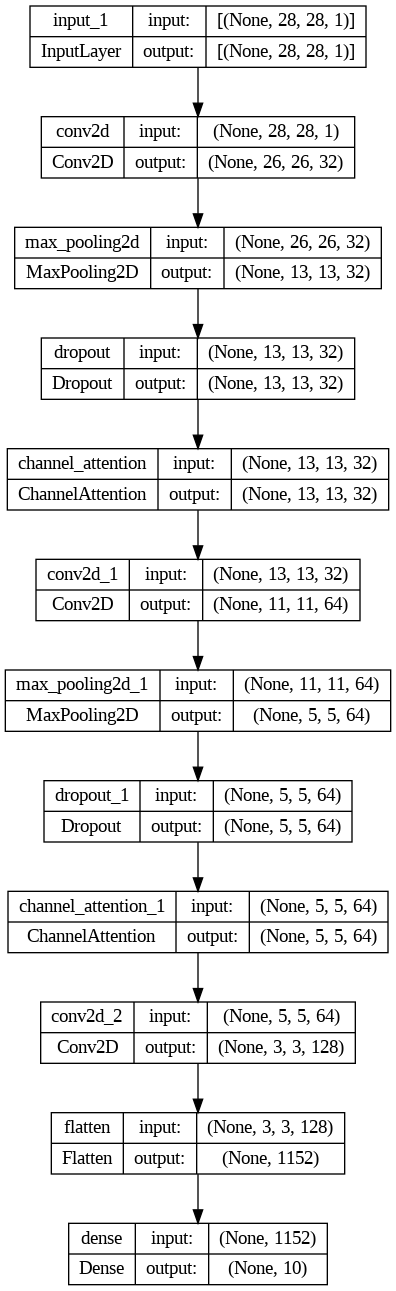

In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as KL
import tensorflow.keras.models as KM
from tensorflow.keras.utils import plot_model

# Define the Channel Attention mechanism
class ChannelAttention(tf.keras.layers.Layer):
    def __init__(self, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        self.reduction_ratio = reduction_ratio

    def build(self, input_shape):
        channels = input_shape[-1]
        self.avg_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.fc = tf.keras.Sequential([
            tf.keras.layers.Dense(channels // self.reduction_ratio, activation='relu'),
            tf.keras.layers.Dense(channels, activation='sigmoid')
        ])

    def call(self, inputs):
        avg_pool = self.avg_pool(inputs)
        channel_attention = self.fc(avg_pool)
        return inputs * tf.expand_dims(tf.expand_dims(channel_attention, 1), 1)

## Dataset
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train, x_test = np.expand_dims(x_train, axis=-1), np.expand_dims(x_test, axis=-1)

## Model
inputs = KL.Input(shape=(28, 28, 1))
c = KL.Conv2D(32, (3, 3), padding="valid", activation=tf.nn.relu)(inputs)
m = KL.MaxPool2D((2, 2), (2, 2))(c)
d = KL.Dropout(0.5)(m)
# Apply Channel Attention mechanism here
ca1 = ChannelAttention()(d)
c = KL.Conv2D(64, (3, 3), padding="valid", activation=tf.nn.relu)(ca1)
m = KL.MaxPool2D((2, 2), (2, 2))(c)
d = KL.Dropout(0.5)(m)
# Apply Channel Attention mechanism here
ca2 = ChannelAttention()(d)
c = KL.Conv2D(128, (3, 3), padding="valid", activation=tf.nn.relu)(ca2)
f = KL.Flatten()(c)
outputs = KL.Dense(10, activation=tf.nn.softmax)(f)

model = KM.Model(inputs, outputs)
model.summary()
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

model.fit(x_train, y_train, epochs=5)
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test Loss: {0} - Test Acc: {1}".format(test_loss, test_acc))
plot_model(model, to_file='model_map.png', show_shapes=True)
